In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Libor Curve Ringing

Based on notebooks\products\rates\FINIBORSINGLECURVE_BuildingInterpolationChoice.ipynb

We examine the impact of the choice of the interpolation scheme

In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
from financepy.utils import *
from financepy.products.rates import *
from financepy.market.curves import *

We start by defining this useful function

In [15]:
# %matplotlib widget
# %matplotlib auto
def plotCurve(curve, start_date, tmax, instr_mat_dates_or_tenor = None, title = ''):
    # years = np.linspace(1/365, tmax, 500)
    years = np.linspace(1/365, tmax, int(365*tmax))
    dates = start_date.add_years(years)
    zero_rates = curve.zero_rate(dates)
    on_fwd_rates = curve.fwd(dates)

    ys_monthly = np.arange(1,tmax*12+1)/12
    monthly_dates = start_date.add_years(ys_monthly)

    if instr_mat_dates_or_tenor is not None:
        # Will plot term forward rates
        # instr_mat_dates_or_tenor could be a list of curve-building
        # isntrument maturities in which case term fwd rates go from the last instrument maturiy date that is less
        # than the plotting date to the plotting date. Or it could be a tenor so that fwd rates cover that tenor 
        # i.e. the term fwd rate for d covers [max(d-tenor,start_date), d]
        # tenor should be a positive tenor

        if isinstance(instr_mat_dates_or_tenor, str):
            neg_tenor = '-' + instr_mat_dates_or_tenor
            start_fwd_dates = [d.add_tenor(neg_tenor) for d in dates]
            start_fwd_dates = [d if d > start_date else start_date for d in start_fwd_dates]
            fwd_rate_label = f'term fwd rates for [d-{instr_mat_dates_or_tenor},d]'
        else:
            instr_mat_dates_or_tenor = [start_date] + instr_mat_dates_or_tenor
            start_fwd_dates = [ max([md  for md in instr_mat_dates_or_tenor if md < d]) for d in dates]
            fwd_rate_label = 'term fwd rates from prev instr mtrty'

        term_fwd_rates = curve.fwd_rate(start_fwd_dates, dates)

    plt.figure(figsize=(8,6))
    plt.plot(years*12, zero_rates*100, '-', label="zero rates")
    plt.plot(years*12, on_fwd_rates*100, '-', label = "ON fwd rates")
    plt.plot(ys_monthly*12, curve.zero_rate(monthly_dates)*100, 'o', label="zero rates (input)")

    if instr_mat_dates_or_tenor is not None:
        plt.plot(years*12, term_fwd_rates*100, '-', label = fwd_rate_label)

    plt.xlabel("Times in months")
    plt.ylabel("Rates (%) - See Legend")
    plt.title(title)
    plt.legend()

## Deposits Only

We use deposits only for simplicity

### Piecewise Flat Interpolation

In [16]:
spot_date = Date(6, 6, 2018)

In [17]:
spot_days = 0
settlement_date = spot_date.add_weekdays(spot_days)
depoDCCType = DayCountTypes.ACT_360

In [18]:
# Flat curve with the 1M rate 50 b bps lower

depos = []
# depo = IborDeposit(settlement_date, "1W", 0.0150, depoDCCType); depos.append(depo)
depo = IborDeposit(settlement_date, "1M", 0.0150, depoDCCType); depos.append(depo)
depo = IborDeposit(settlement_date, "2M", 0.0200, depoDCCType); depos.append(depo)
depo = IborDeposit(settlement_date, "3M", 0.0200, depoDCCType); depos.append(depo)
depo = IborDeposit(settlement_date, "4M", 0.0200, depoDCCType); depos.append(depo)
depo = IborDeposit(settlement_date, "5M", 0.0200, depoDCCType); depos.append(depo)
depo = IborDeposit(settlement_date, "6M", 0.0200, depoDCCType); depos.append(depo)
depo_mat_dates = [d.maturity_dt for d in depos]

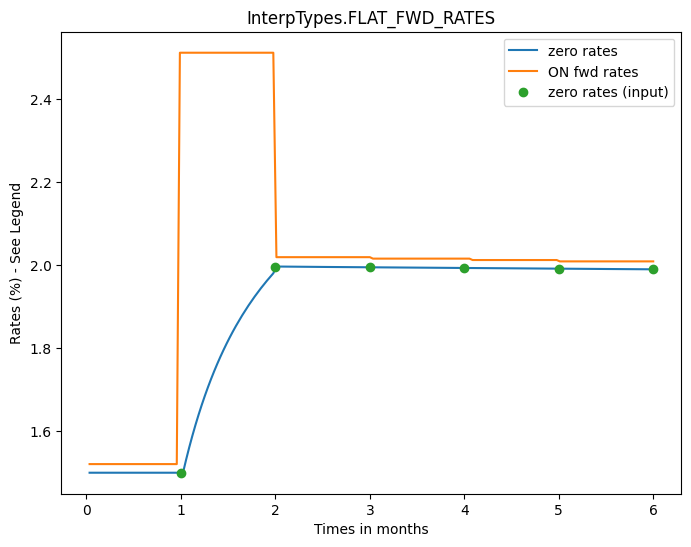

In [19]:
libor_curve = IborSingleCurve(settlement_date, depos, [], [])
# print(libor_curve)
plotCurve(libor_curve, settlement_date, 0.5, title = InterpTypes.FLAT_FWD_RATES)

The shape of the forwards is an artifact of the piecewise flat interpolation scheme and the fact that Actual 360 deposit rates do not compare directly to zero rates or continuously compounded forwards.

### Piecewise Linear Forwards Interpolation

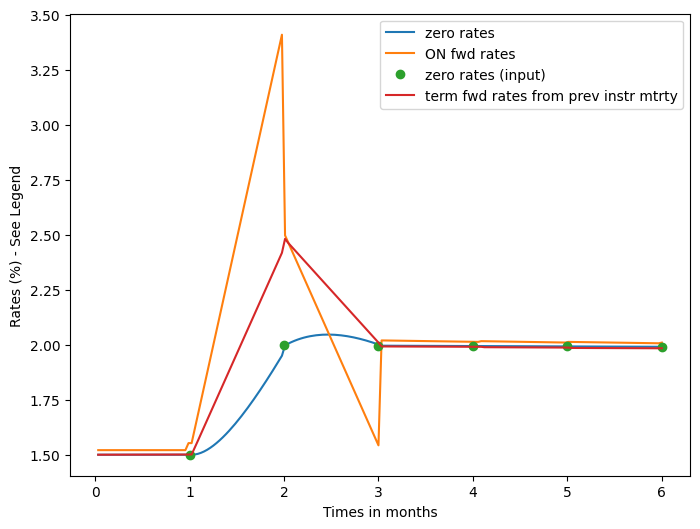

In [20]:
# No need to redefine
# depos = []
# depo = IborDeposit(settlement_date, "1M", 0.0230, depoDCCType); depos.append(depo)
# depo = IborDeposit(settlement_date, "2M", 0.0235, depoDCCType); depos.append(depo)
# depo = IborDeposit(settlement_date, "3M", 0.0240, depoDCCType); depos.append(depo)
# depo = IborDeposit(settlement_date, "6M", 0.0220, depoDCCType); depos.append(depo)

libor_curve = IborSingleCurve(settlement_date, depos, [], [], InterpTypes.LINEAR_FWD_RATES)
plotCurve(libor_curve, settlement_date, 0.5, instr_mat_dates_or_tenor=depo_mat_dates)
# plotCurve(libor_curve, settlement_date, 0.5, instr_mat_dates_or_tenor='2W')

### Piecewise Linear Zero Rates

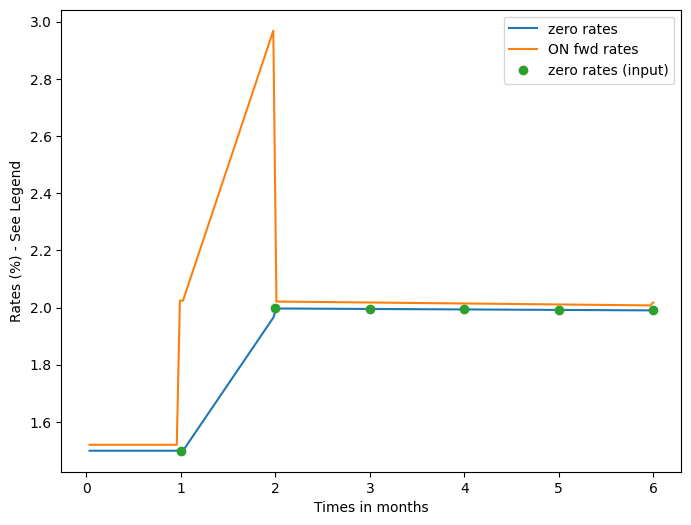

In [21]:
libor_curve = IborSingleCurve(settlement_date, depos, [], [], InterpTypes.LINEAR_ZERO_RATES)
plotCurve(libor_curve, settlement_date, 0.5)

In [22]:
# class InterpTypes(Enum):
#     FLAT_FWD_RATES = 1
#     LINEAR_FWD_RATES = 2
#     LINEAR_ZERO_RATES = 4
#     FINCUBIC_ZERO_RATES = 7
#     NATCUBIC_LOG_DISCOUNT = 8
#     NATCUBIC_ZERO_RATES = 9
#     PCHIP_ZERO_RATES = 10
#     PCHIP_LOG_DISCOUNT = 11

# from class PchipInterpolator(CubicHermiteSpline):
#     ``x`` and ``y`` are arrays of values used to approximate some function f,
#     with ``y = f(x)``. The interpolant uses monotonic cubic splines
#     to find the value of new points. (PCHIP stands for Piecewise Cubic
#     Hermite Interpolating Polynomial).

### Let's try all available interpolators

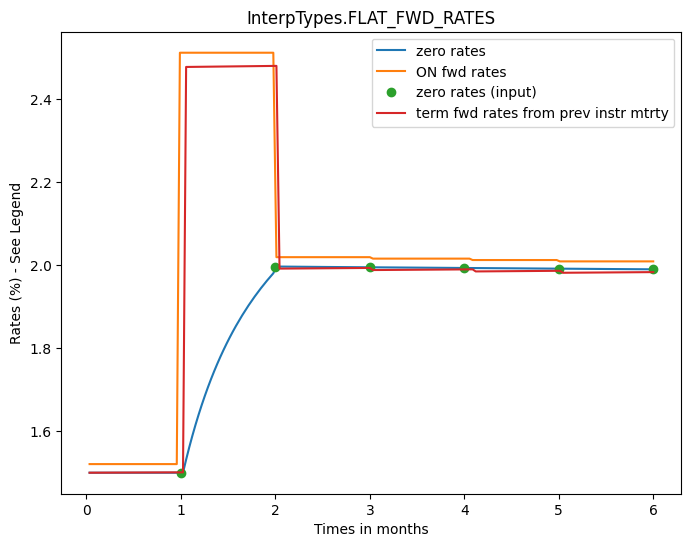

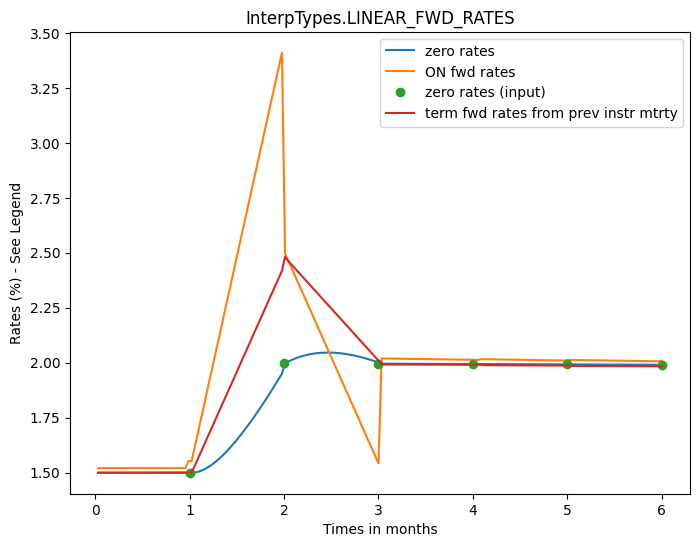

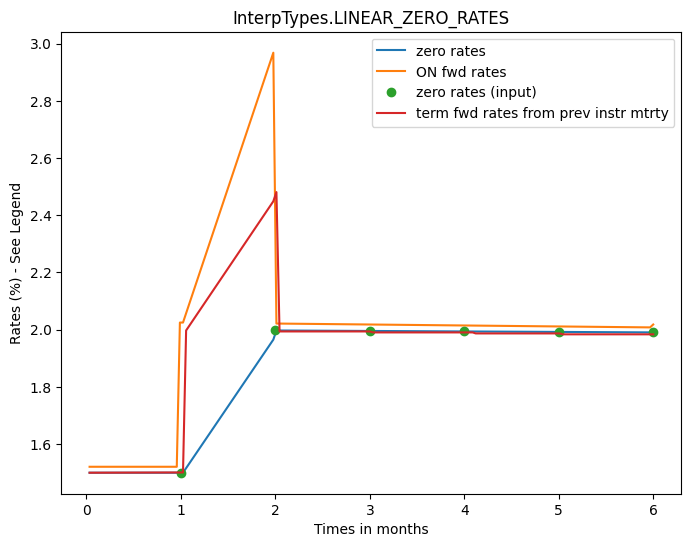

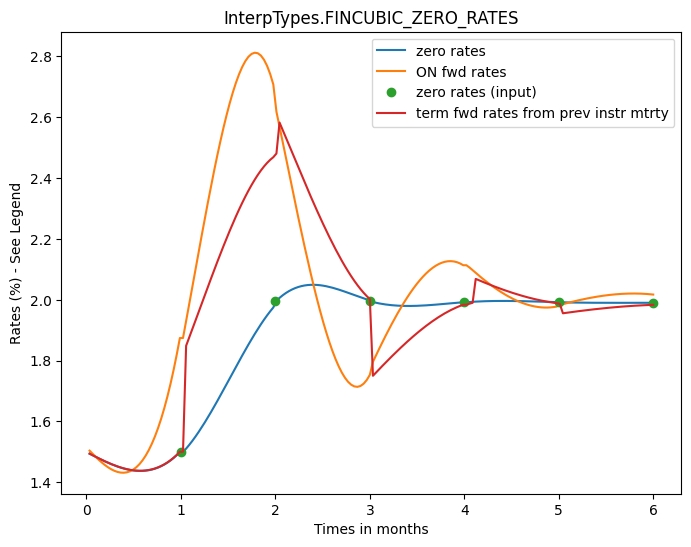

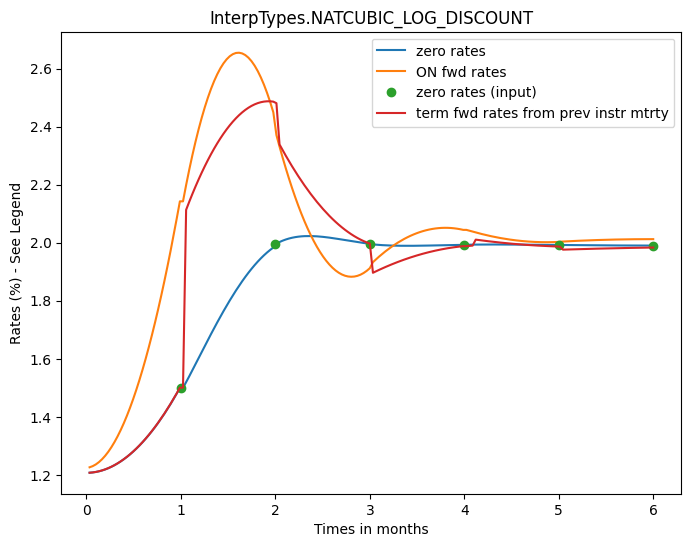

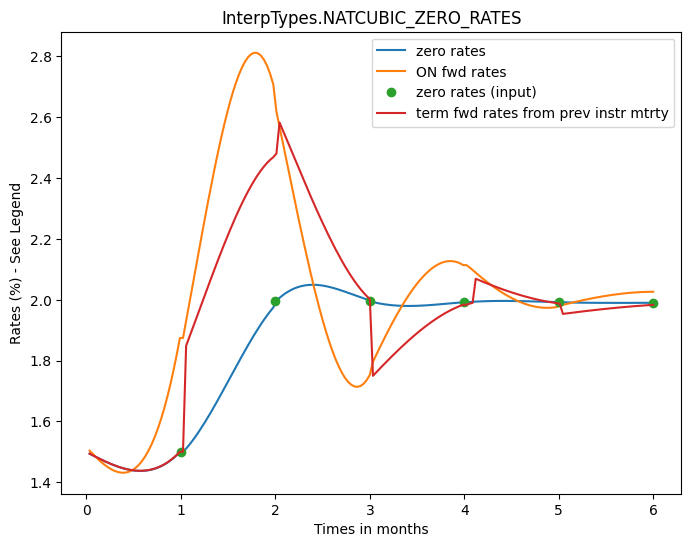

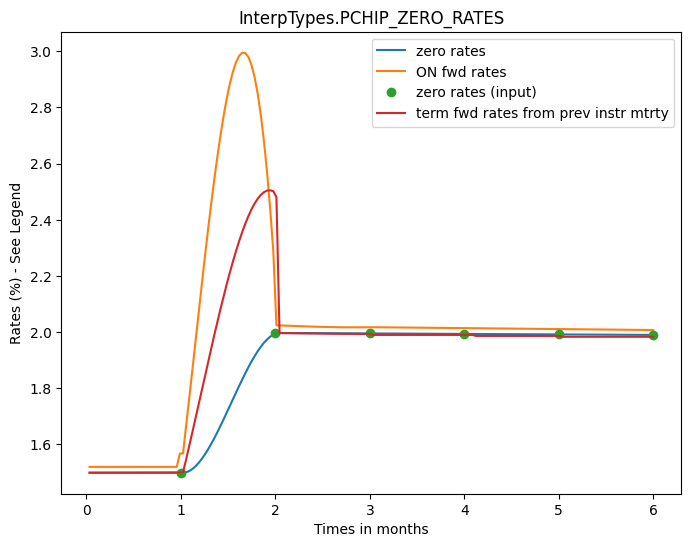

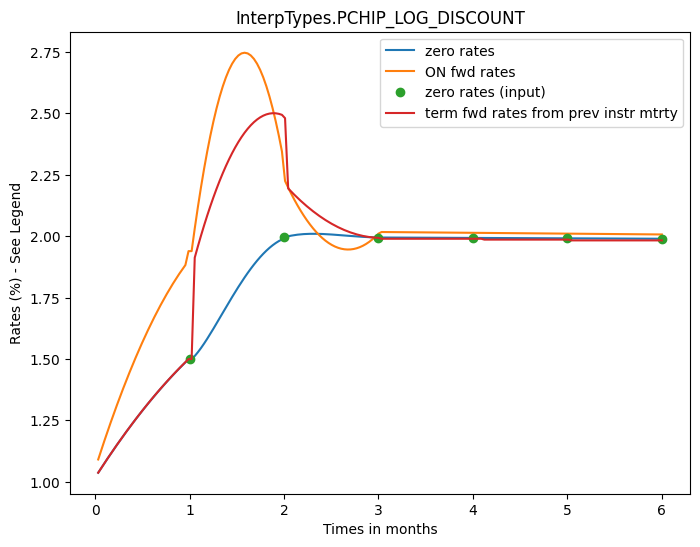

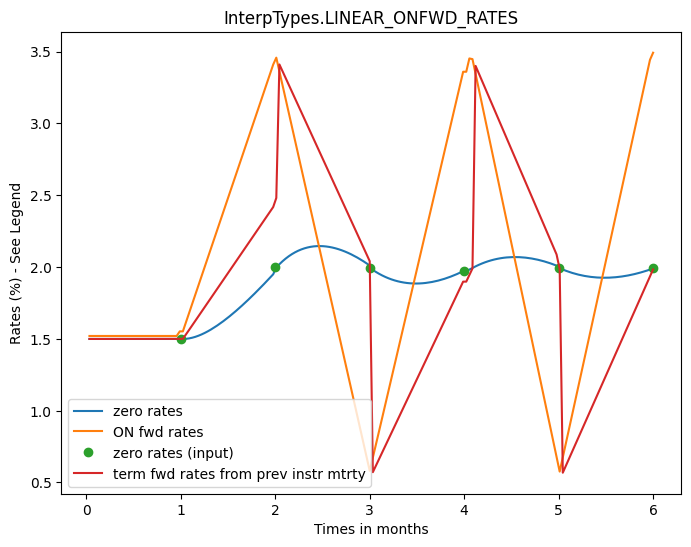

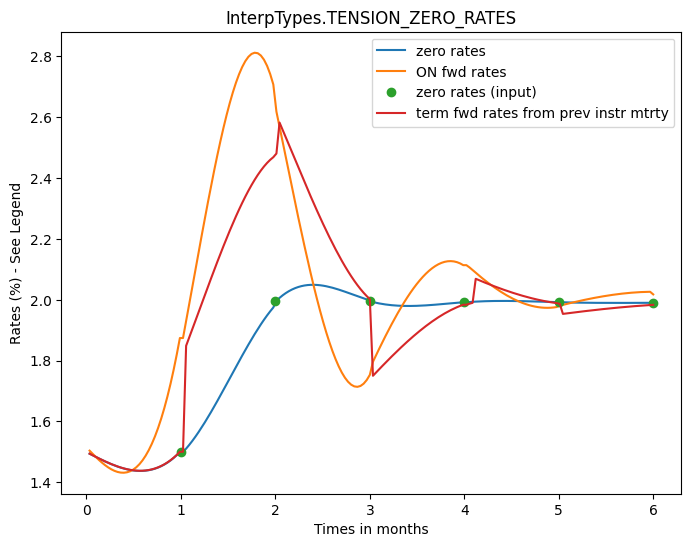

In [23]:
for interp_type in InterpTypes:
    libor_curve = IborSingleCurve(settlement_date, depos, [], [], interp_type)
    plotCurve(libor_curve, settlement_date, 0.5, instr_mat_dates_or_tenor=depo_mat_dates, title = interp_type)

### Plot all available interpolators with fixed-tenor fwd rates

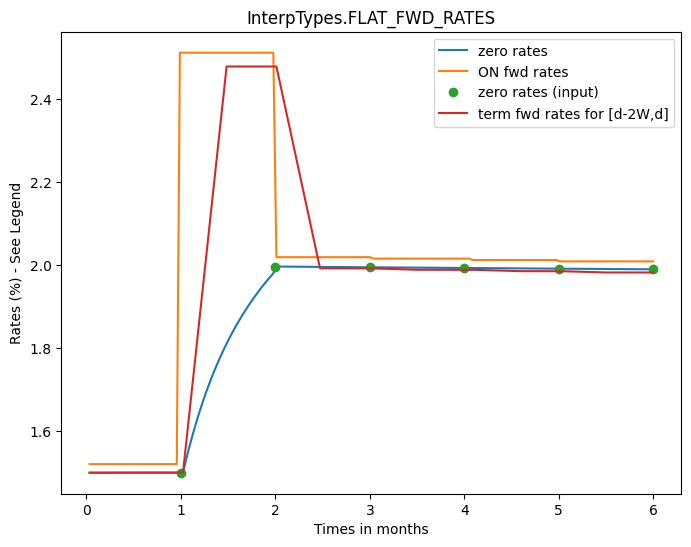

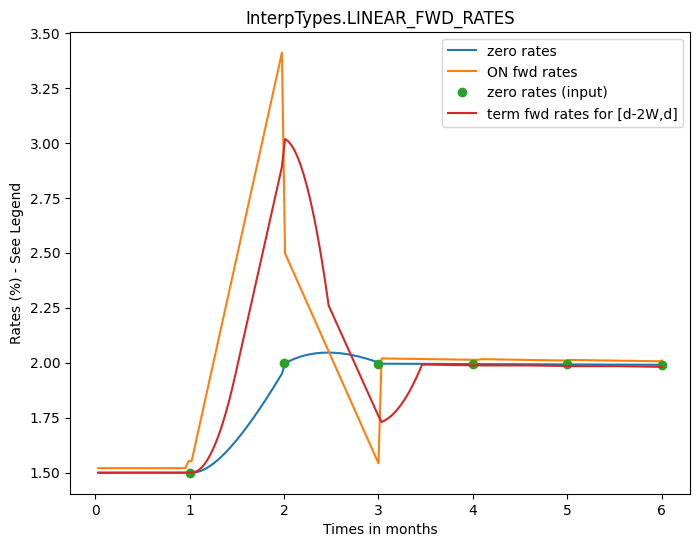

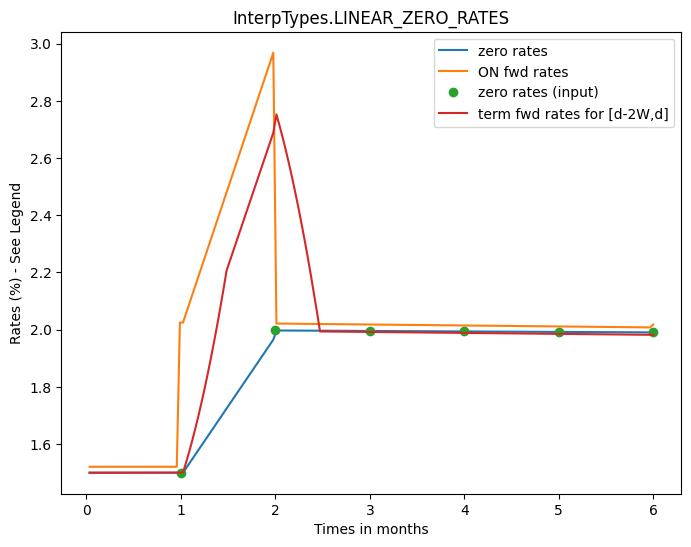

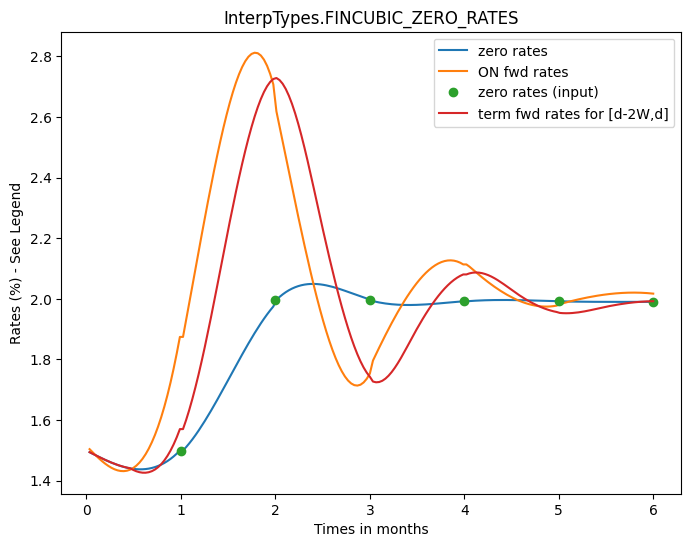

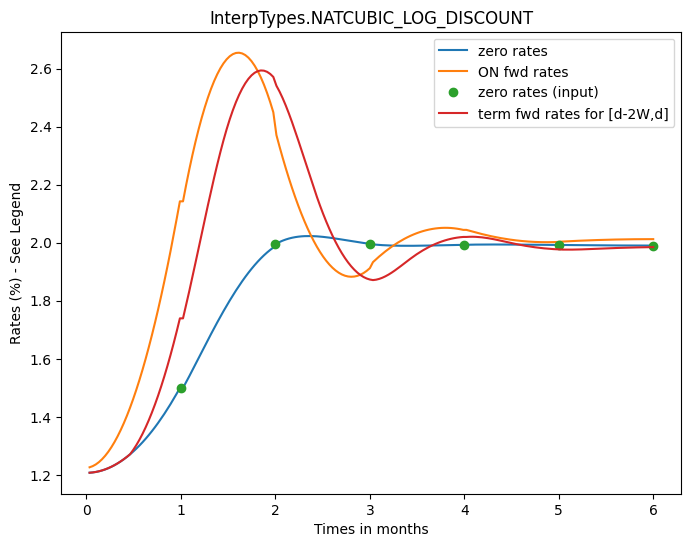

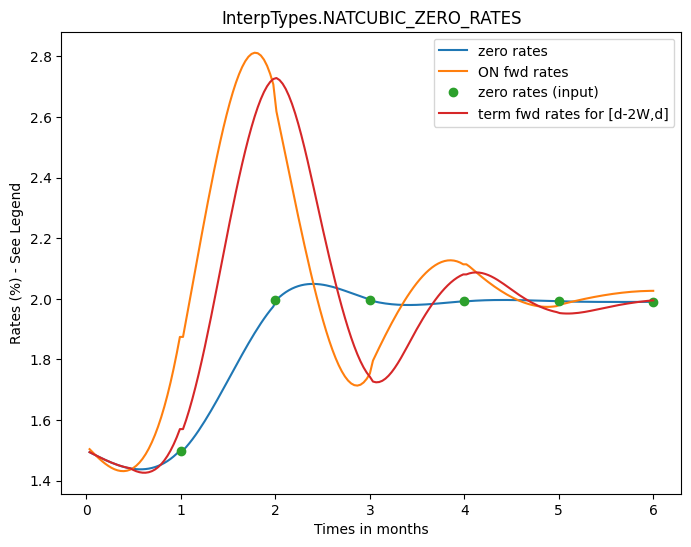

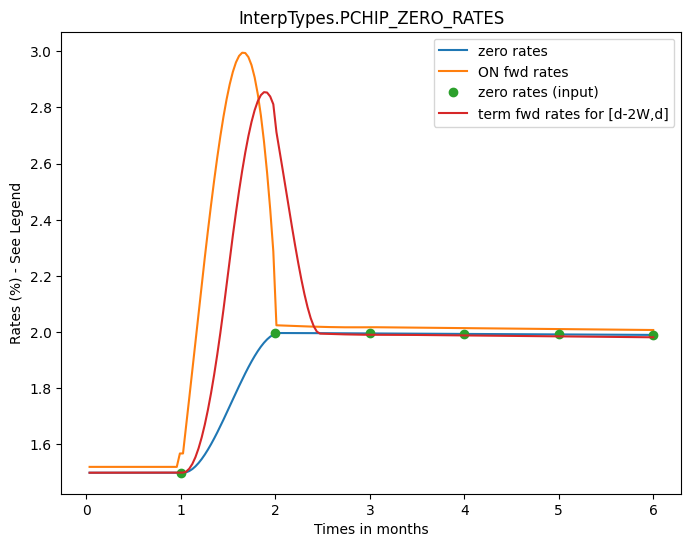

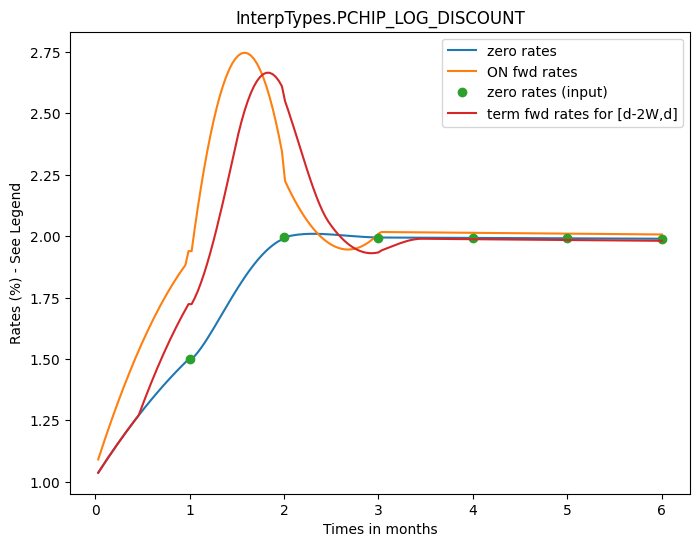

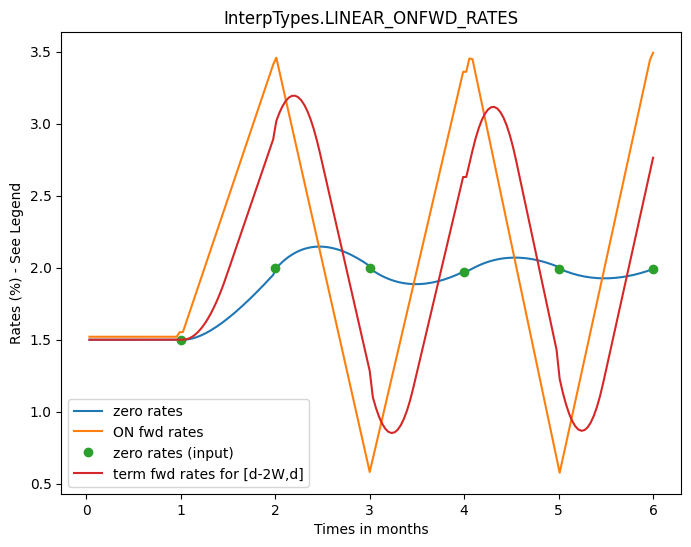

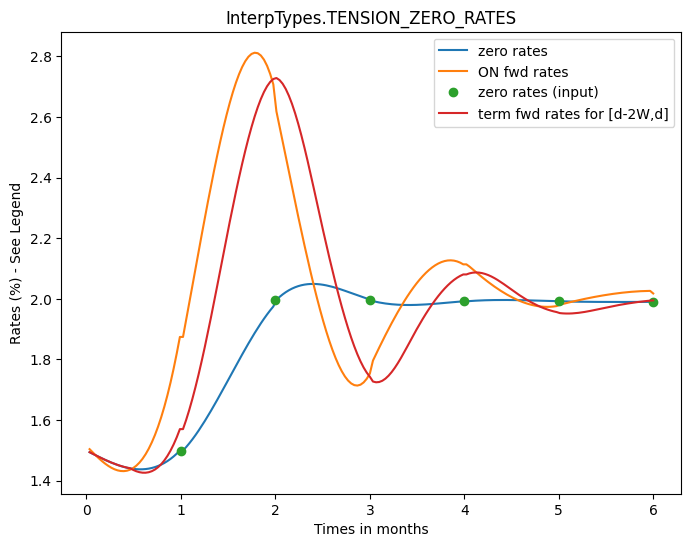

In [24]:
for interp_type in InterpTypes:
    libor_curve = IborSingleCurve(settlement_date, depos, [], [], interp_type)
    plotCurve(libor_curve, settlement_date, 0.5, instr_mat_dates_or_tenor='2W', title = interp_type)